In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sricharan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sricharan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv("imdb_master.csv", encoding='latin1')
df.dropna(inplace=True)

Loading dataset...


In [3]:
# Keep only labeled data (remove 'unsup')
print("Filtering labeled data...")
df = df[df['label'] != 'unsup']

# Mapping labels to numerical values
df['label'] = df['label'].map({'neg': 0, 'pos': 1})

# Preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z ]', ' ', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos='v'), pos='n') for word in words]
    cleaned_words = [word for word in lemmatized_words if word not in stop_words]  # Remove stopwords
    return ' '.join(cleaned_words)

print("Cleaning text data...")
df['clean_review'] = df['review'].apply(clean_text)


Filtering labeled data...
Cleaning text data...


Generating word clouds...


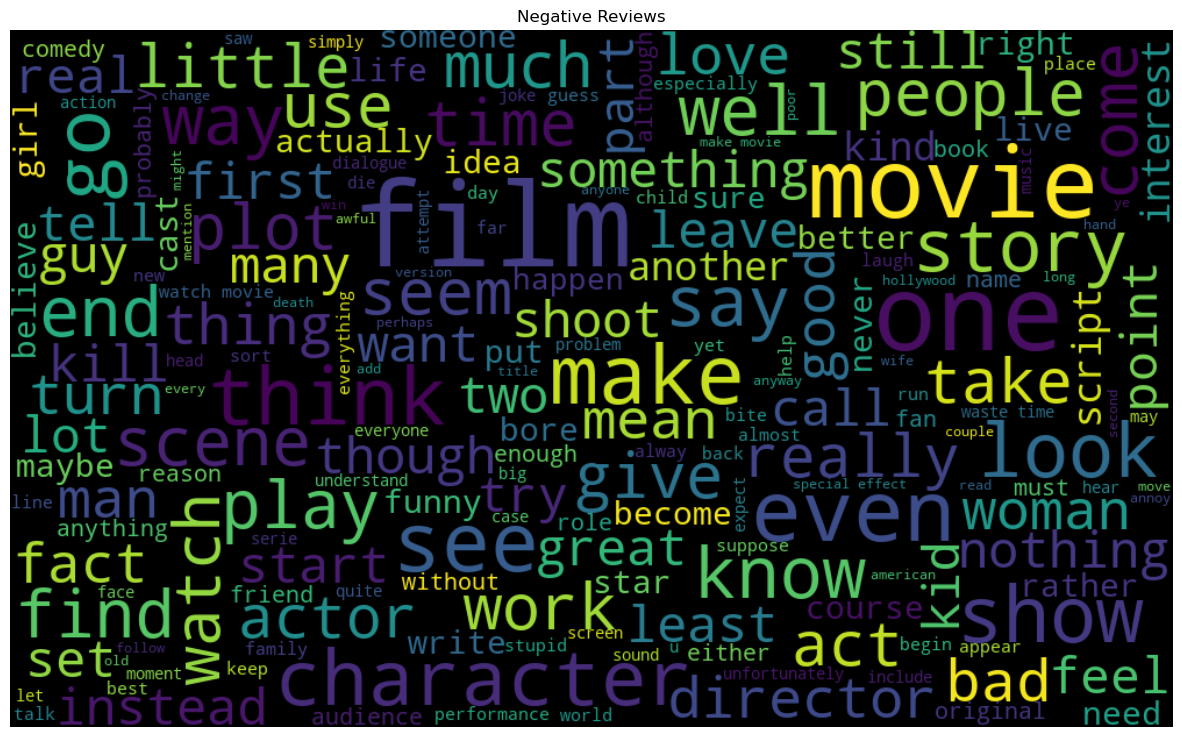

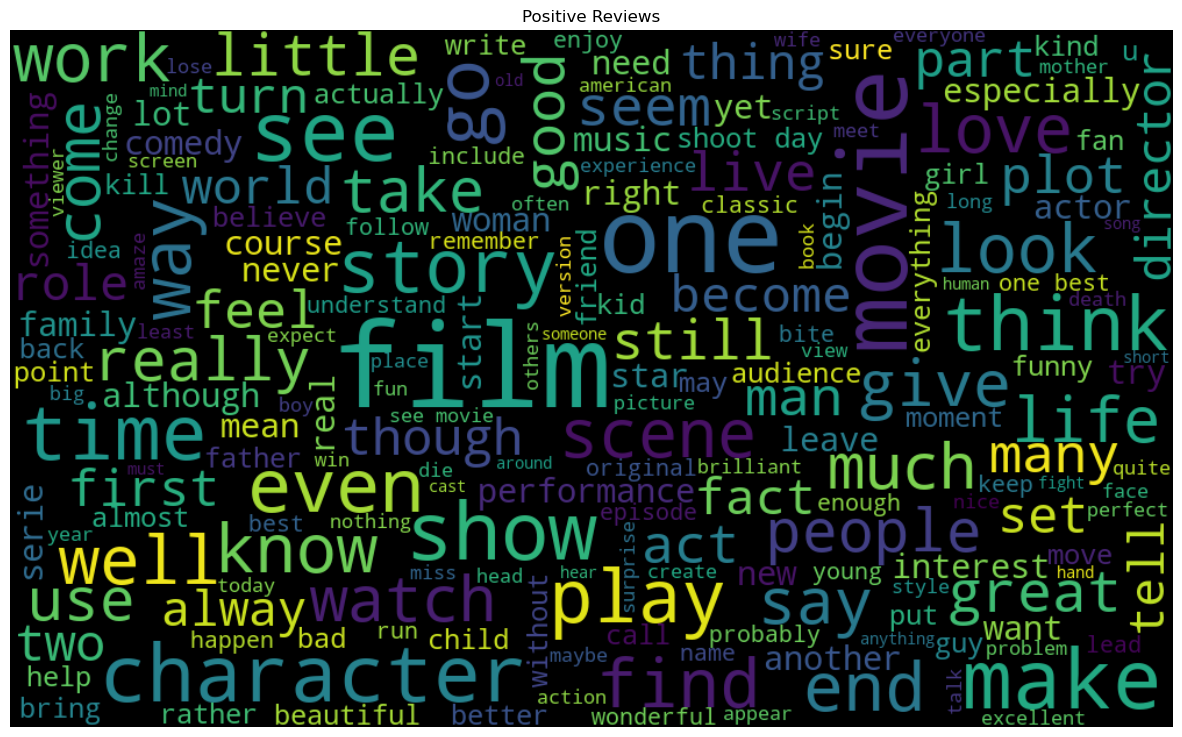

In [4]:
# Generate Word Clouds
print("Generating word clouds...")
for sentiment, title in [(0, 'Negative Reviews'), (1, 'Positive Reviews')]:
    reviews = ' '.join(df['clean_review'][df['label'] == sentiment].astype(str))
    wordcloud = WordCloud(height=600, width=1000, max_font_size=100).generate(reviews)
    plt.figure(figsize=(15, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


In [5]:
df.to_csv('cleaned_data.csv')

In [6]:
# Splitting data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['label'], test_size=0.2, random_state=42)

Splitting data...


In [7]:
# TF-IDF Vectorization
print("Applying TF-IDF vectorization...")
vectorizer = TfidfVectorizer(max_features=2500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Get the selected words (features) by TF-IDF
selected_words = vectorizer.get_feature_names_out()

# Display the first 50 wo
selected_words

Applying TF-IDF vectorization...


array(['abandon', 'ability', 'able', ..., 'youth', 'zero', 'zombie'],
      dtype=object)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define hyperparameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 30.0]}

# Initialize model
nb = MultinomialNB()

# Apply GridSearchCV
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Get best parameters
best_alpha = grid_search.best_params_['alpha']
print(f"✅ Best Alpha for Naïve Bayes: {best_alpha}")

# Train final model with best alpha
best_nb = MultinomialNB(alpha=best_alpha)
best_nb.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_nb = best_nb.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, y_pred_nb)
print(f"✅ Final Naïve Bayes Accuracy: {nb_acc:.4f}")


Fitting 5 folds for each of 7 candidates, totalling 35 fits
✅ Best Alpha for Naïve Bayes: 5.0
✅ Final Naïve Bayes Accuracy: 0.8509


<Axes: >

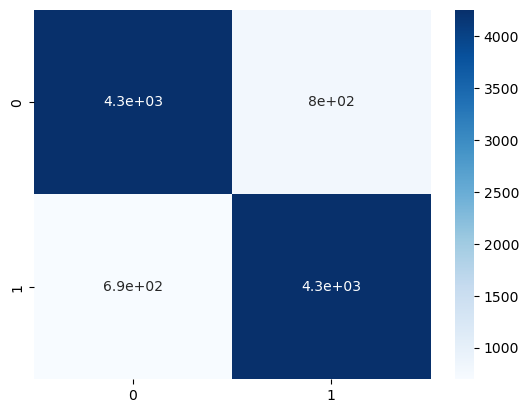

In [17]:
sns.heatmap( confusion_matrix(y_test, y_pred_nb),annot=True, cmap="Blues")

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Reduce dimensions using Truncated SVD (better for sparse data)
n_components = 100  # Adjust based on memory and performance
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Transform train and test data
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

print(f"✅ Reduced feature dimensions from {X_train_tfidf.shape[1]} to {n_components}")


✅ Reduced feature dimensions from 2500 to 100


 Running KNN for different values of K...


Processing KNN: 100%|██████████| 20/20 [15:02<00:00, 45.13s/model]


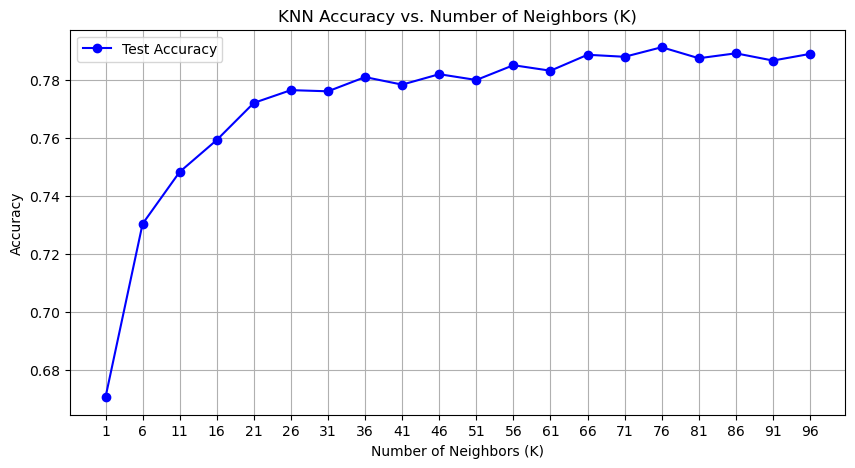

✅ Done! Check the plot for the best K value.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Progress bar

# Define range of K values to test
k_values = range(1, 101, 5)  # Testing K from 1 to 100 in steps of 5
accuracies = []

print(" Running KNN for different values of K...")

# Train and evaluate KNN for each K with tqdm progress bar
for k in tqdm(k_values, desc="Processing KNN", unit="model"):
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='uniform')
    knn.fit(X_train_reduced, y_train)
    
    y_pred = knn.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot K vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors (K)")
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()

print("✅ Done! Check the plot for the best K value.")


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize KNN with fixed parameters
knn = KNeighborsClassifier(n_neighbors=76, metric='manhattan', weights='uniform')

# Train the model
knn.fit(X_train_reduced, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test_reduced)

# Evaluate final model
knn_acc = accuracy_score(y_test, y_pred_knn)

print(f"✅ Final KNN Accuracy on Test Set: {knn_acc:.4f}")


✅ Final KNN Accuracy on Test Set: 0.7913


<Axes: >

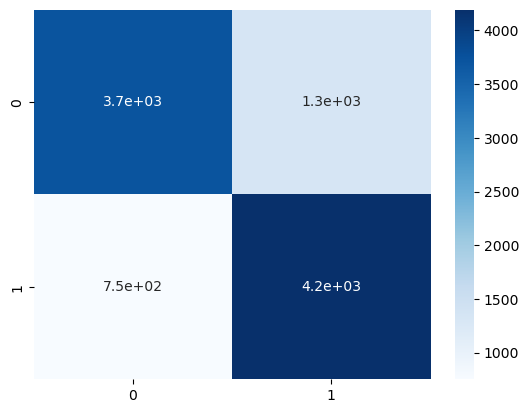

In [14]:
sns.heatmap( confusion_matrix(y_test, y_pred_knn), cmap="Blues", annot=True)

In [ ]:
# SVM Classifier with optimized parameters
print("\nTraining SVM...")
svm_model = SVC(kernel='linear', C=1, probability=True)
svm_model.fit(X_train_tfidf, y_train)
print("\nPredicting with SVM...")
y_pred_svm = svm_model.predict(X_test_reduced)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"\n✅ SVM Accuracy: {svm_acc:.4f}")


Training SVM...


In [1]:
# Hyperparameter tuning for Random Forest
print("\nTuning Random Forest hyperparameters...")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1, verbose=3)
rf_grid.fit(X_train_tfidf, y_train)
best_rf = rf_grid.best_estimator_
print(f"\n✅ Best Random Forest Parameters: {rf_grid.best_params_}")
# Training Random Forest
print("\nTraining Random Forest...")
best_rf.fit(X_train_tfidf, y_train)
print("\nPredicting with Random Forest...")
y_pred_rf = best_rf.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"\n✅ Random Forest Accuracy: {rf_acc:.4f}")


Tuning Random Forest hyperparameters...


NameError: name 'GridSearchCV' is not defined

In [ ]:
# Tokenizing for LSTM & RNN
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [ ]:
# LSTM Model
print("\nTraining LSTM Model...")
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, epochs=3, batch_size=64, validation_data=(X_test_seq, y_test))
lstm_acc = lstm_model.evaluate(X_test_seq, y_test)[1]
print(f"\n✅ LSTM Accuracy: {lstm_acc:.4f}")


In [ ]:
# Minimal RNN Model
print("\nTraining Minimal RNN Model...")
minimal_rnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=200),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

minimal_rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
minimal_rnn_model.fit(X_train_seq, y_train, epochs=5, batch_size=64, verbose=1)
y_pred_minimal_rnn = (minimal_rnn_model.predict(X_test_seq) > 0.5).astype(int)
minimal_rnn_acc = accuracy_score(y_test, y_pred_minimal_rnn)
print(f"\n✅ Minimal RNN Accuracy: {minimal_rnn_acc:.4f}")

In [ ]:
# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

models = {
    'Naive Bayes': y_pred_nb,
    'KNN': y_pred_knn,
    'SVM': y_pred_svm,
    'Random Forest': y_pred_rf,
    'LSTM': (lstm_model.predict(X_test_seq) > 0.5).astype(int),
    'Minimal RNN': y_pred_minimal_rnn
}

for model_name, y_pred in models.items():
    plot_confusion_matrix(y_test, y_pred, model_name)

In [ ]:
# Performance Metrics Comparison
metrics = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'AUC': {}}
for name, pred in models.items():
    metrics['Accuracy'][name] = accuracy_score(y_test, pred)
    report = classification_report(y_test, pred, output_dict=True)
    metrics['Precision'][name] = report['1']['precision']
    metrics['Recall'][name] = report['1']['recall']
    metrics['AUC'][name] = roc_auc_score(y_test, pred)

for metric, values in metrics.items():
    plt.figure(figsize=(8, 5))
    plt.bar(values.keys(), values.values())
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison of Models')
    plt.show()